# Imports

In [7]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt
import numpy as np

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Processing

## Selection of features

In [8]:
#Selection of existing relevant features per game : events that happened during each game
relevant_features = ['Date','HomeTeam','AwayTeam','IWH','IWD','IWA','FTR','FTHG','FTAG','HTHG','HTAG','HS','AS',
                     'HST','AST','HF','AF','HY','AY','HR','AR','HC','AC']

## Function for data processing of each season : creation of relevant features

In [9]:
def create_stat_dico(season: str, league: str) -> pd.DataFrame:
    
    """Compute statistics for a given season all the relevant statistics by going through each game
    
    Output a Dataframe of each game and each team statistics before the game
    
    Arguments : name of the season as a string, name of the league as a string
    """
    
    #stat_seasons is a 3-layer nested dico :
    # stats_season ---> dico of all clubs
    # club ---> dico of all week results
    # week ---> all stats for that week
    # stat ---> value for that specific game
     
    stats_season = {}
    file_name = '../Football_Data/Entire_Data_' + league + '.xlsx'
    xls_file = pd.ExcelFile(file_name)
    table = xls_file.parse(season)[relevant_features].dropna(axis=0)
    
    ###Features that describe team before the game
    table['week'] = 0
    
    ###For Home Team (HT)
    table['HT_average_points'] = 0.0
    table['HT_average_goal_scored_half_1'] = 0.0
    table['HT_average_goal_conceeded_half_1'] = 0.0
    table['HT_average_goal_scored_half_2'] = 0.0
    table['HT_average_goal_conceeded_half_2'] = 0.0
    table['HT_average_yellow'] = 0.0
    table['HT_average_red'] = 0.0
    table['HT_average_shots_per_goal'] = 0.0
    table['HT_on_target_precision'] = 0.0
    table['HT_average_shots_conceeded'] = 0.0
    table['HT_average_fouls_committed'] = 0.0
    table['HT_average_fouls_conceeded'] = 0.0
    
    ###For Away Team (AT)
    table['AT_average_points'] = 0.0
    table['AT_average_goal_scored_half_1'] = 0.0
    table['AT_average_goal_conceeded_half_1'] = 0.0
    table['AT_average_goal_scored_half_2'] = 0.0
    table['AT_average_goal_conceeded_half_2'] = 0.0
    table['AT_average_yellow'] = 0.0
    table['AT_average_red'] = 0.0
    table['AT_average_shots_per_goal'] = 0.0
    table['AT_on_target_precision'] = 0.0
    table['AT_average_shots_conceeded'] = 0.0
    table['AT_average_fouls_committed'] = 0.0
    table['AT_average_fouls_conceeded'] = 0.0
    
    #Number of weeks available
    nb_weeks = int(len(table)/10)
    
    if season == '2019-2020':
        nb_weeks = int(len(table)/10) - 1
    
    #Getting unique list of club names for this season
    clubs = list(set(list(table['HomeTeam'])))

    #Creation of the dictionary of stats for each club       
    for c in clubs:
        
        #First layer of dict
        stats_season[c] = {}
        
        #Selection of the games where the club is involved
        isHome = table['HomeTeam'] == c
        isAway = table['AwayTeam'] == c
        selected = table.loc[isHome | isAway]
        stats_season[c]['games_index'] = list(selected.index)
        
        
        #Initialisation of week 0 for additive params
        stats_season[c][0] = {}
        stats_season[c][0]['league_points'] = 0.0
        stats_season[c][0]['goals_scored'] = 0.0
        stats_season[c][0]['goals_scored_half'] = 0.0
        stats_season[c][0]['goals_conceeded'] = 0.0
        stats_season[c][0]['goals_conceeded_half'] = 0.0
        stats_season[c][0]['yellow'] = 0.0
        stats_season[c][0]['red'] = 0.0
        stats_season[c][0]['fouls_conceeded'] = 0.0
        stats_season[c][0]['fouls_committed'] = 0.0
        stats_season[c][0]['shots'] = 0.0
        stats_season[c][0]['shots_on_target'] = 0.0
        stats_season[c][0]['shots_conceeded'] = 0.0
        
        #Going through all the weeks of the season
        for k in range(1,len(selected)):
            
            #Second layer of dict
            stats_season[c][k] = {}
            
            #Third layer of dict
            if selected['AwayTeam'][selected.index[k-1]] == c :
                stats_season[c][k]['is_Home'] = False
            else :
                stats_season[c][k]['is_Home'] = True
            
            #Modifying the dataframe to add the statistics before game (based on previous weeks) use as features for ML
            if stats_season[c][k]['is_Home']:
                table.at[selected.index[k-1],'week'] = k
                table.at[selected.index[k-1],'HT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            else :
                table.at[selected.index[k-1],'AT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
                
            #Gathering the statistics of the game for the club for next games
            #League points
            if selected['FTR'][selected.index[k-1]] == "D" :
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 1.0
            elif selected['FTR'][selected.index[k-1]] == "A" and selected['AwayTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            elif selected['FTR'][selected.index[k-1]] == "H" and selected['HomeTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            else:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points']
            
            #Goals and shots
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['HS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['HST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['AS'][selected.index[k-1]]
            else :
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['AS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['AST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['HS'][selected.index[k-1]]
            
            #Fouls and cards
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['HY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['HR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['AF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['HF'][selected.index[k-1]]
            else:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['AY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['AR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['HF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['AF'][selected.index[k-1]]
  
    return(table)

## Processing selected data

In [10]:
#List of all features created after processing
processed_features = ['week', 'HT_average_points', 'HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2', 'HT_average_yellow', 'HT_average_red',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded', 'HT_average_fouls_committed',
           'HT_average_fouls_conceeded', 
           'AT_average_points', 'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2', 'AT_average_yellow', 'AT_average_red',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded', 'AT_average_fouls_committed',
           'AT_average_fouls_conceeded', 'FTR','IWH','IWD','IWA']

#Leagues selected
chosen_leagues = ['PL'] # 'Ligue1','LaLiga','SerieA','Bundesliga'

#Seasons selected
start_year = 2012
end_year = 2020

data_seasons = {}

for i in range(start_year,end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    data_seasons[season] = {}
    
    for league in chosen_leagues:
        
        print("Processing " + league + ' ' + str(i) + '-' + str(i+1))

        table = create_stat_dico(season, league)

        full_table_add = table[processed_features]
 
        data_seasons[season][league] = full_table_add


Processing PL 2012-2013
Processing PL 2013-2014
Processing PL 2014-2015
Processing PL 2015-2016
Processing PL 2016-2017
Processing PL 2017-2018
Processing PL 2018-2019
Processing PL 2019-2020


## Visualize data final format

In [11]:
#Visualize the format of dataframe
full_table_add

,week,HT_average_points,HT_average_goal_scored_half_1,HT_average_goal_conceeded_half_1,HT_average_goal_scored_half_2,HT_average_goal_conceeded_half_2,HT_average_yellow,HT_average_red,HT_average_shots_per_goal,HT_on_target_precision,...,AT_average_red,AT_average_shots_per_goal,AT_on_target_precision,AT_average_shots_conceeded,AT_average_fouls_committed,AT_average_fouls_conceeded,FTR,IWH,IWD,IWA
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,1.15,8.00,18.00
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,11.00,6.10,1.25
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,D,1.97,3.55,3.80
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,2.65,3.20,2.75
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,D,3.10,3.20,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,9.60,5.50,1.30
256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,3.95,3.80,1.87
257,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,1.45,4.50,7.00
258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,1.85,3.60,4.30


# Defining train and test datasets

## Training dataset

In [12]:
#Selection of seasons used to train
train_start_year = 2012
train_end_year = 2017

train_chosen_leagues = ['PL'] #'Ligue1','LaLiga','SerieA','Bundesliga'

train_df = pd.DataFrame(columns = processed_features)

for i in range(train_start_year,train_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in train_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [train_df, table]
        
        train_df = pd.concat(two_concat)
       

#Starting week of training
start_week_train = 20
valid = train_df['week'] > start_week_train
train_df = train_df[valid]
        
print("The model will train on : " + str(train_chosen_leagues))
        
print("The model will train on " + str(len(train_df)) + " matches from " + str(train_start_year) + '-' + str(train_start_year+1) + " to " + str(train_end_year-1) + '-' + str(train_end_year) + " !")

#Choice of the features
features = ['HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded',
           'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded']

n_features = len(features)

train_x = train_df[features]

train_y = train_df['FTR']


The model will train on : ['PL']
The model will train on 848 matches from 2012-2013 to 2016-2017 !


## Testing dataset

In [13]:
#Selection of seasons used to test
test_start_year = train_end_year
test_end_year = 2020

test_df = pd.DataFrame(columns = processed_features)

test_chosen_leagues = ['PL'] # 'Ligue1','LaLiga','SerieA','Bundesliga'

for i in range(test_start_year, test_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in test_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [test_df, table]
        
        test_df = pd.concat(two_concat)

#Starting week of training
start_week_test = 20
valid = test_df['week'] > start_week_test
test_df = test_df[valid]

#Choice of the features (we first delete the odds)
test_x = test_df[features]

#Labels for training
test_y = test_df['FTR']


print("The model will test on : " + str(test_chosen_leagues))
      
print("The model will test on " + str(len(test_df)) + " matches from " + str(test_start_year) + '-' + str(test_start_year+1) + " to " + str(test_end_year-1) + '-' + str(test_end_year) + " !")



The model will test on : ['PL']
The model will test on 389 matches from 2017-2018 to 2019-2020 !


# Let's apply classical ML algorithms

## Importing models

In [16]:
#Dealing with format and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#Classical classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemblist models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

## Training and testing : getting probabilities for test data

### GridSearch on Random Forest

In [17]:
parameters = {'n_estimators':[100,200], 'max_depth':[25,100], 'min_samples_split':[5,10]}

forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, 
                                n_jobs=None, random_state=None)

RFClassifier = GridSearchCV(forest, parameters,verbose=100)

name = 'RF'

print("Training " + name + " ...")
RFClassifier.fit(train_x, train_y)

y_pred = RFClassifier.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
#Calculate probabilities:
probas = RFClassifier.predict_proba(test_x)
;

Training RF ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=25, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=100, score=0.424, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=25, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=100, score=0.547, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=25, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=100, score=0.506, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=25, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=25, min_samples_split=5, n_estimators=100, sc

[CV]  max_depth=100, min_samples_split=10, n_estimators=100, score=0.562, total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    9.2s remaining:    0.0s
[CV] max_depth=100, min_samples_split=10, n_estimators=200 ...........
[CV]  max_depth=100, min_samples_split=10, n_estimators=200, score=0.394, total=   0.4s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    9.6s remaining:    0.0s
[CV] max_depth=100, min_samples_split=10, n_estimators=200 ...........
[CV]  max_depth=100, min_samples_split=10, n_estimators=200, score=0.535, total=   0.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    9.9s remaining:    0.0s
[CV] max_depth=100, min_samples_split=10, n_estimators=200 ...........
[CV]  max_depth=100, min_samples_split=10, n_estimators=200, score=0.506, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   10.3s remaining:    0.0s
[CV] max_depth=100, min_samples_split=10, n_estimators=200 ...........
[CV]  max_depth=100, min_samples_split=10, n

''

### Testing various models

In [31]:
# Dealing with parameters
C = 0.8

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga', tol=0.000001,
                                      multi_class='multinomial',
                                      max_iter=1000000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga', tol=0.000001,
                                                    multi_class='multinomial',
                                                    max_iter=1000000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=25, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, bootstrap=True, oob_score=False, 
                                            n_jobs=None, random_state=None)
}

n_classifiers = len(classifiers)

results = {}

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training " + name + "...")
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    #Calculate probabilities:
    probas = classifier.predict_proba(test_x)
    
    #store them in a dict
    results[name] = probas
;

Training L1 logistic...
Accuracy (test) for L1 logistic: 53.0% 
Training L2 logistic (Multinomial)...
Accuracy (test) for L2 logistic (Multinomial): 53.5% 
Training L2 logistic (OvR)...
Accuracy (test) for L2 logistic (OvR): 52.7% 
Training Random Forest...
Accuracy (test) for Random Forest: 51.7% 


''

# Let's try with Neural Networks

## Imports

In [32]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#Keras tuners
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

#Time
import time

## Parameters

In [33]:
n_classes = 3
n_features = train_x.shape[1]
n_epochs = 10

## Preprocessing

In [34]:
test_X = test_x.values
test_Y = test_y.values
train_X = train_x.values
train_Y = train_y.values

#Features
min_max_scaler = preprocessing.MinMaxScaler()
train_X_scaled = min_max_scaler.fit_transform(train_X)
test_X_scaled = min_max_scaler.transform(test_X)

#Labels
# integer encode
label_encoder = LabelEncoder()
train_Y_integer_encoded = label_encoder.fit_transform(train_Y)
test_Y_integer_encoded = label_encoder.transform(test_Y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_Y_integer_encoded = train_Y_integer_encoded.reshape(len(train_Y_integer_encoded), 1)
train_Y_onehot_encoded = onehot_encoder.fit_transform(train_Y_integer_encoded)
test_Y_integer_encoded = test_Y_integer_encoded.reshape(len(test_Y_integer_encoded), 1)
test_Y_onehot_encoded = onehot_encoder.transform(test_Y_integer_encoded)


## Searching for a relevant architecture model

In [35]:
log_dir = f"{int(time.time())}"

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
    
    for i in range(hp.Int("n_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Int(f"layer_{i}_neurons",min_value = 10, max_value = 200, step = 20), activation =tf.nn.relu))

    #Output layer
    model.add(tf.keras.layers.Dense(n_classes,activation =tf.nn.softmax))

    #Compile
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ["accuracy"])
    return model


In [36]:
tuner = RandomSearch(
        build_model,
        objective = "val_acc",
        max_trials = 10,
        executions_per_trial = 2,
        directory = log_dir
        )

tuner.search(x = train_X_scaled,
             y = train_Y_onehot_encoded,
             epochs = 10,
             batch_size = 25,
             validation_data = (test_X_scaled, test_Y_onehot_encoded))

;

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1253 - acc: 0.080 - 0s 117us/sample - loss: 1.0483 - acc: 0.4540 - val_loss: 1.0129 - val_acc: 0.5501
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.1144 - acc: 0.320 - 0s 40us/sample - loss: 0.9985 - acc: 0.5354 - val_loss: 0.9909 - val_acc: 0.5398
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 0.9672 - acc: 0.520 - 0s 47us/sample - loss: 0.9759 - acc: 0.5472 - val_loss: 0.9916 - val_acc: 0.5244
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9577 - acc: 0.560 - 0s 43us/sample - loss: 0.9719 - acc: 0.5531 - val_loss: 0.9969 - val_acc: 0.5398
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.9659 - acc: 0.520 - 0s 42us/sample - loss: 0.9658 - acc: 0.5637 - val_loss: 0.9928 - val_acc: 0.5193
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 1.0740 - acc: 0.40

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.0977 - acc: 0.320 - 0s 121us/sample - loss: 1.0398 - acc: 0.4611 - val_loss: 1.0053 - val_acc: 0.5296
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 0.9727 - acc: 0.480 - 0s 46us/sample - loss: 0.9951 - acc: 0.5413 - val_loss: 1.0017 - val_acc: 0.5013
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 0.9858 - acc: 0.560 - 0s 45us/sample - loss: 0.9868 - acc: 0.5472 - val_loss: 0.9952 - val_acc: 0.5064
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9111 - acc: 0.640 - 0s 44us/sample - loss: 0.9738 - acc: 0.5554 - val_loss: 0.9956 - val_acc: 0.5244
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.9484 - acc: 0.520 - 0s 50us/sample - loss: 0.9659 - acc: 0.5590 - val_loss: 0.9899 - val_acc: 0.5321
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 0.8994 - acc: 0.60

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1205 - acc: 0.240 - 0s 128us/sample - loss: 1.0788 - acc: 0.4257 - val_loss: 1.0509 - val_acc: 0.4756
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0305 - acc: 0.560 - 0s 40us/sample - loss: 1.0474 - acc: 0.4682 - val_loss: 1.0335 - val_acc: 0.4756
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 1.0418 - acc: 0.440 - 0s 48us/sample - loss: 1.0127 - acc: 0.4835 - val_loss: 1.0083 - val_acc: 0.5424
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9212 - acc: 0.600 - 0s 41us/sample - loss: 0.9930 - acc: 0.5590 - val_loss: 0.9981 - val_acc: 0.5373
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.8689 - acc: 0.760 - 0s 41us/sample - loss: 0.9899 - acc: 0.5531 - val_loss: 0.9885 - val_acc: 0.5373
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 1.0545 - acc: 0.60

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1207 - acc: 0.320 - 0s 104us/sample - loss: 1.0323 - acc: 0.4658 - val_loss: 0.9915 - val_acc: 0.5424
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0781 - acc: 0.440 - 0s 39us/sample - loss: 0.9861 - acc: 0.5460 - val_loss: 0.9789 - val_acc: 0.5347
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 0.8611 - acc: 0.640 - 0s 39us/sample - loss: 0.9712 - acc: 0.5542 - val_loss: 1.0111 - val_acc: 0.4859
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 1.0991 - acc: 0.440 - 0s 42us/sample - loss: 0.9636 - acc: 0.5696 - val_loss: 0.9891 - val_acc: 0.5270
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.9772 - acc: 0.520 - 0s 42us/sample - loss: 0.9624 - acc: 0.5613 - val_loss: 0.9865 - val_acc: 0.5347
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 1.0722 - acc: 0.36

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1127 - acc: 0.200 - 0s 117us/sample - loss: 1.0331 - acc: 0.4800 - val_loss: 0.9883 - val_acc: 0.5296
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0330 - acc: 0.480 - 0s 43us/sample - loss: 0.9848 - acc: 0.5413 - val_loss: 0.9968 - val_acc: 0.5244
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 0.8359 - acc: 0.640 - 0s 41us/sample - loss: 0.9667 - acc: 0.5613 - val_loss: 0.9969 - val_acc: 0.5116
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9214 - acc: 0.640 - 0s 49us/sample - loss: 0.9625 - acc: 0.5696 - val_loss: 0.9851 - val_acc: 0.5321
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.9497 - acc: 0.600 - 0s 52us/sample - loss: 0.9553 - acc: 0.5708 - val_loss: 0.9940 - val_acc: 0.5347
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 1.1010 - acc: 0.44

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1092 - acc: 0.120 - 0s 132us/sample - loss: 1.0706 - acc: 0.4458 - val_loss: 1.0261 - val_acc: 0.4884
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0276 - acc: 0.520 - 0s 49us/sample - loss: 1.0075 - acc: 0.5236 - val_loss: 0.9835 - val_acc: 0.5296
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 0.8839 - acc: 0.680 - 0s 51us/sample - loss: 0.9745 - acc: 0.5472 - val_loss: 0.9780 - val_acc: 0.5321
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9764 - acc: 0.480 - 0s 46us/sample - loss: 0.9837 - acc: 0.5271 - val_loss: 0.9808 - val_acc: 0.5219
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 1.0210 - acc: 0.480 - 0s 43us/sample - loss: 0.9728 - acc: 0.5483 - val_loss: 0.9877 - val_acc: 0.5244
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 0.9429 - acc: 0.64

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.0743 - acc: 0.480 - 0s 107us/sample - loss: 1.0504 - acc: 0.4646 - val_loss: 1.0160 - val_acc: 0.4987
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 0.9847 - acc: 0.480 - 0s 44us/sample - loss: 1.0165 - acc: 0.5142 - val_loss: 0.9991 - val_acc: 0.5398
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 1.0761 - acc: 0.440 - 0s 39us/sample - loss: 0.9935 - acc: 0.5448 - val_loss: 0.9818 - val_acc: 0.5398
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.8772 - acc: 0.640 - 0s 34us/sample - loss: 0.9785 - acc: 0.5554 - val_loss: 0.9827 - val_acc: 0.5321
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 1.0141 - acc: 0.520 - 0s 36us/sample - loss: 0.9737 - acc: 0.5613 - val_loss: 0.9776 - val_acc: 0.5270
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 1.0657 - acc: 0.52

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.0991 - acc: 0.440 - 0s 123us/sample - loss: 1.0253 - acc: 0.4941 - val_loss: 0.9942 - val_acc: 0.5476
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0287 - acc: 0.440 - 0s 46us/sample - loss: 0.9765 - acc: 0.5542 - val_loss: 0.9896 - val_acc: 0.5219
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 1.0339 - acc: 0.480 - 0s 47us/sample - loss: 0.9697 - acc: 0.5767 - val_loss: 0.9855 - val_acc: 0.5193
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 1.0075 - acc: 0.440 - 0s 47us/sample - loss: 0.9685 - acc: 0.5660 - val_loss: 1.0012 - val_acc: 0.5167
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.7599 - acc: 0.720 - 0s 49us/sample - loss: 0.9660 - acc: 0.5625 - val_loss: 0.9835 - val_acc: 0.5476
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 0.9190 - acc: 0.56

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.0964 - acc: 0.400 - 0s 136us/sample - loss: 1.0375 - acc: 0.4717 - val_loss: 1.0023 - val_acc: 0.5476
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0853 - acc: 0.440 - 0s 49us/sample - loss: 0.9873 - acc: 0.5483 - val_loss: 1.0083 - val_acc: 0.4807
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 1.0822 - acc: 0.440 - 0s 45us/sample - loss: 0.9764 - acc: 0.5519 - val_loss: 0.9900 - val_acc: 0.5321
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.9275 - acc: 0.560 - 0s 43us/sample - loss: 0.9715 - acc: 0.5507 - val_loss: 0.9781 - val_acc: 0.5270
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 1.0577 - acc: 0.480 - 0s 43us/sample - loss: 0.9629 - acc: 0.5625 - val_loss: 0.9790 - val_acc: 0.5321
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 0.9305 - acc: 0.64

Train on 848 samples, validate on 389 samples
Epoch 1/10
848/848 [==============================] - ETA: 0s - loss: 1.1014 - acc: 0.240 - 0s 140us/sample - loss: 1.0389 - acc: 0.4670 - val_loss: 1.0038 - val_acc: 0.5244
Epoch 2/10
848/848 [==============================] - ETA: 0s - loss: 1.0284 - acc: 0.480 - 0s 58us/sample - loss: 0.9861 - acc: 0.5554 - val_loss: 0.9935 - val_acc: 0.5347
Epoch 3/10
848/848 [==============================] - ETA: 0s - loss: 1.2257 - acc: 0.400 - 0s 49us/sample - loss: 0.9767 - acc: 0.5448 - val_loss: 0.9920 - val_acc: 0.5141
Epoch 4/10
848/848 [==============================] - ETA: 0s - loss: 0.8454 - acc: 0.680 - 0s 52us/sample - loss: 0.9677 - acc: 0.5566 - val_loss: 0.9804 - val_acc: 0.5219
Epoch 5/10
848/848 [==============================] - ETA: 0s - loss: 0.9876 - acc: 0.520 - 0s 53us/sample - loss: 0.9648 - acc: 0.5672 - val_loss: 0.9814 - val_acc: 0.5296
Epoch 6/10
848/848 [==============================] - ETA: 0s - loss: 0.8763 - acc: 0.64

INFO:tensorflow:Oracle triggered exit


''

In [41]:
print("The best hyperparemeters found are : ")
print(tuner.get_best_hyperparameters()[0].values)
print("The summary for the best model : ")
print(tuner.get_best_models()[0].summary())

The best hyperparemeters found are : 
{'n_input_neurons': 150, 'n_layers': 2, 'layer_0_neurons': 30, 'layer_1_neurons': 110, 'layer_2_neurons': 30}
The summary for the best model : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               2250      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                4530      
_________________________________________________________________
dense_2 (Dense)              (None, 110)               3410      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 333       
Total params: 10,523
Trainable params: 10,523
Non-trainable params: 0
_________________________________________________________________
None


## Choosing final model

In [42]:
final_model = tuner.get_best_models()[0]
    
#Fit
final_model.fit(train_X_scaled, train_Y_onehot_encoded,
          batch_size=20,
          epochs=100,
          validation_data=(test_X_scaled, test_Y_onehot_encoded))

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results_ = final_model.evaluate(test_X_scaled, test_Y_onehot_encoded, batch_size=128)
print('test loss, test acc:', results_)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = final_model.predict(test_X_scaled[:3])
print('predictions shape:', predictions.shape)

;

Train on 848 samples, validate on 389 samples
Epoch 1/100
848/848 [==============================] - ETA: 0s - loss: 0.9625 - acc: 0.650 - 0s 83us/sample - loss: 0.9534 - acc: 0.5719 - val_loss: 0.9839 - val_acc: 0.5167
Epoch 2/100
848/848 [==============================] - ETA: 0s - loss: 0.8015 - acc: 0.650 - 0s 49us/sample - loss: 0.9543 - acc: 0.5767 - val_loss: 0.9804 - val_acc: 0.5373
Epoch 3/100
848/848 [==============================] - ETA: 0s - loss: 0.8193 - acc: 0.650 - 0s 50us/sample - loss: 0.9477 - acc: 0.5708 - val_loss: 1.0118 - val_acc: 0.5553
Epoch 4/100
848/848 [==============================] - ETA: 0s - loss: 0.7379 - acc: 0.650 - 0s 52us/sample - loss: 0.9543 - acc: 0.5601 - val_loss: 0.9733 - val_acc: 0.5270
Epoch 5/100
848/848 [==============================] - ETA: 0s - loss: 0.9116 - acc: 0.550 - 0s 54us/sample - loss: 0.9482 - acc: 0.5814 - val_loss: 0.9818 - val_acc: 0.5296
Epoch 6/100
848/848 [==============================] - ETA: 0s - loss: 1.1258 - acc:

Epoch 32/100
848/848 [==============================] - ETA: 0s - loss: 0.8772 - acc: 0.550 - 0s 45us/sample - loss: 0.8585 - acc: 0.6203 - val_loss: 1.0246 - val_acc: 0.5347
Epoch 33/100
848/848 [==============================] - ETA: 0s - loss: 0.7132 - acc: 0.750 - 0s 47us/sample - loss: 0.8700 - acc: 0.6132 - val_loss: 1.0095 - val_acc: 0.5296
Epoch 34/100
848/848 [==============================] - ETA: 0s - loss: 0.7452 - acc: 0.700 - 0s 46us/sample - loss: 0.8527 - acc: 0.6274 - val_loss: 1.0590 - val_acc: 0.5141
Epoch 35/100
848/848 [==============================] - ETA: 0s - loss: 0.6954 - acc: 0.750 - 0s 47us/sample - loss: 0.8465 - acc: 0.6415 - val_loss: 1.0377 - val_acc: 0.5398
Epoch 36/100
848/848 [==============================] - ETA: 0s - loss: 0.5449 - acc: 0.850 - 0s 44us/sample - loss: 0.8464 - acc: 0.6179 - val_loss: 1.0257 - val_acc: 0.5296
Epoch 37/100
848/848 [==============================] - ETA: 0s - loss: 0.7236 - acc: 0.750 - 0s 47us/sample - loss: 0.8368 -

Epoch 79/100
848/848 [==============================] - ETA: 0s - loss: 0.5450 - acc: 0.750 - 0s 46us/sample - loss: 0.5829 - acc: 0.7630 - val_loss: 1.3367 - val_acc: 0.5116
Epoch 80/100
848/848 [==============================] - ETA: 0s - loss: 0.6228 - acc: 0.750 - 0s 44us/sample - loss: 0.5621 - acc: 0.7653 - val_loss: 1.3014 - val_acc: 0.4910
Epoch 81/100
848/848 [==============================] - ETA: 0s - loss: 0.4366 - acc: 0.850 - 0s 46us/sample - loss: 0.5712 - acc: 0.7689 - val_loss: 1.3883 - val_acc: 0.5116
Epoch 82/100
848/848 [==============================] - ETA: 0s - loss: 0.4764 - acc: 0.850 - 0s 44us/sample - loss: 0.5722 - acc: 0.7618 - val_loss: 1.4177 - val_acc: 0.5219
Epoch 83/100
848/848 [==============================] - ETA: 0s - loss: 0.6633 - acc: 0.800 - 0s 46us/sample - loss: 0.5581 - acc: 0.7807 - val_loss: 1.3698 - val_acc: 0.5013
Epoch 84/100
848/848 [==============================] - ETA: 0s - loss: 0.5029 - acc: 0.900 - 0s 46us/sample - loss: 0.5329 -

''

# Function to optimize

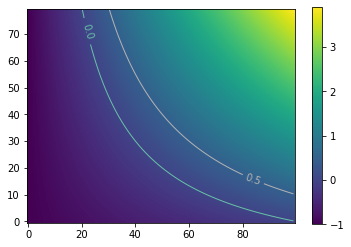

In [43]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (x*y - 1)
 
prob = arange(0.0,1.0,0.01)
odd = arange(1.0,5.0,0.05)
X,Y = meshgrid(prob, odd) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,origin = 'lower') # drawing the function

# adding the Contour lines with labels
cset = contour(Z,[0.0, 0.5],linewidths=1,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im) # adding the colobar on the right

show()

# Performance analysis

## Calculations of expected gain for each result

In [44]:
performance_df = test_df[['FTR','IWA','IWD','IWH']]
performance_df['P(A)']= pd.DataFrame(data = results['Random Forest'][:,0], columns = ['P(A)'])
performance_df['E(A)']= performance_df['P(A)'] * performance_df['IWA'] - 1.0
performance_df['P(D)']= pd.DataFrame(data = results['Random Forest'][:,1], columns = ['P(D)'])
performance_df['E(D)']= performance_df['P(D)'] * performance_df['IWD'] - 1.0
performance_df['P(H)']= pd.DataFrame(data = results['Random Forest'][:,2], columns = ['P(H)'])
performance_df['E(H)']= performance_df['P(H)'] * performance_df['IWH'] - 1.0
performance_df

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H)
200,H,2.90,3.30,2.45,0.142,-0.58820,0.158,-0.47860,0.700,0.71500
201,H,13.00,6.50,1.22,0.294,2.82200,0.331,1.15150,0.375,-0.54250
202,D,2.90,3.10,2.60,0.428,0.24120,0.290,-0.10100,0.282,-0.26680
203,H,8.00,5.30,1.35,0.218,0.74400,0.298,0.57940,0.484,-0.34660
204,D,7.50,4.80,1.40,0.619,3.64250,0.126,-0.39520,0.255,-0.64300
...,...,...,...,...,...,...,...,...,...,...
245,A,2.60,3.30,2.75,0.493,0.28180,0.342,0.12860,0.165,-0.54625
246,D,2.80,3.35,2.55,0.281,-0.21320,0.193,-0.35345,0.526,0.34130
247,D,3.45,3.20,2.20,0.267,-0.07885,0.118,-0.62240,0.615,0.35300
248,D,2.00,3.50,3.70,0.265,-0.47000,0.287,0.00450,0.448,0.65760


## Selection of results to bet on and their actual performances

In [45]:
#Floor and cap on expected gain to consider
floor = 1.0
cap = 15.0

### Draws performance

In [46]:
#Selection of the draws
draw_floor = performance_df['E(D)'] > floor
draw_cap = performance_df['E(D)'] < cap
selected_draw = performance_df[draw_floor & draw_cap]

#Computation of actual gains on draws
selected_draw['Gain'] = 0.0
is_Draw = selected_draw['FTR'] == 'D'
not_Draw = selected_draw['FTR'] != 'D'
selected_draw.loc[not_Draw, 'Gain'] = -1.0
selected_draw.loc[is_Draw, 'Gain'] = selected_draw.loc[is_Draw,'IWD'] - 1.0
selected_draw['Gain'].sum()

5.5

### Aways performance

In [47]:
#Selection of the aways
away_floor = performance_df['E(A)'] > floor
away_cap = performance_df['E(A)'] < cap
selected_away = performance_df[away_floor & away_cap]

#Computation of actual gains on aways
selected_away['Gain'] = 0.0
is_Away = selected_away['FTR'] == 'A'
not_Away = selected_away['FTR'] != 'A'
selected_away.loc[not_Away, 'Gain'] = -1.0
selected_away.loc[is_Away, 'Gain'] = selected_away.loc[is_Away,'IWA'] - 1.0
selected_away['Gain'].sum()

-43.050000000000004

### Homes performance

In [48]:
#Selection of the homes
home_floor = performance_df['E(H)'] > floor
home_cap = performance_df['E(H)'] < cap
selected_home = performance_df[home_floor & home_cap]

#Computation of actual gains on aways
selected_home['Gain'] = 0.0
is_Home = selected_home['FTR'] == 'H'
not_Home = selected_home['FTR'] != 'H'
selected_home.loc[not_Home, 'Gain'] = -1.0
selected_home.loc[is_Home, 'Gain'] = selected_home.loc[is_Home,'IWH'] - 1.0
selected_home['Gain'].sum()

9.6

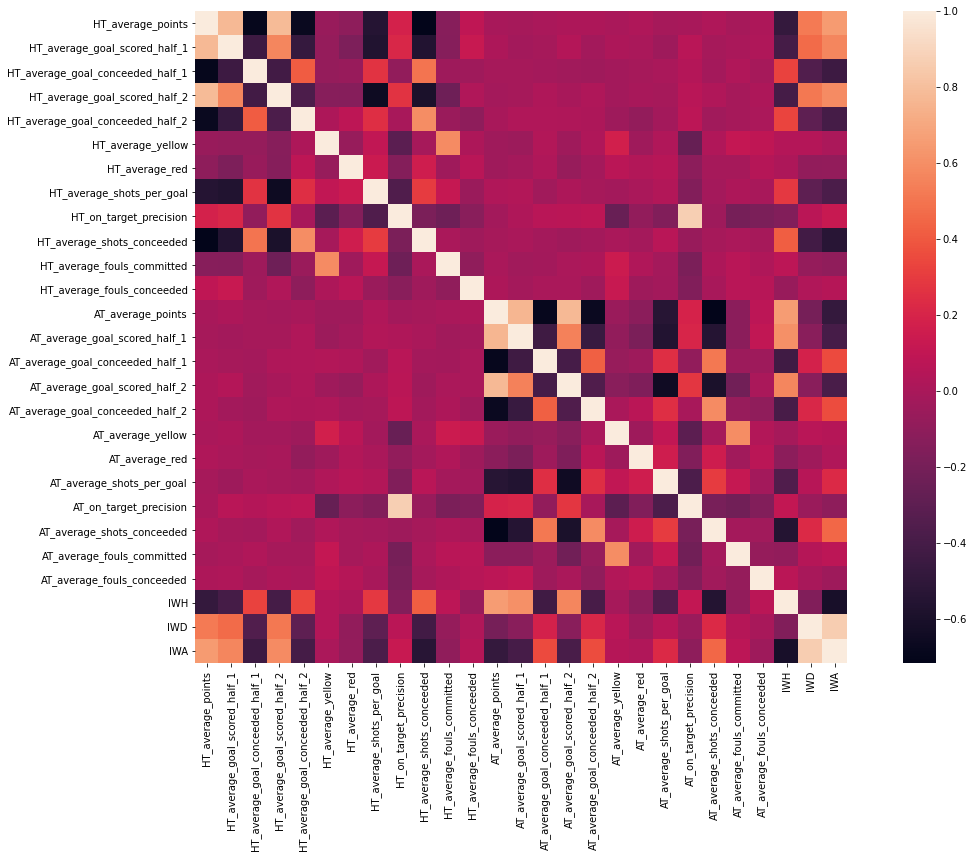

In [49]:
import matplotlib.pyplot as plt
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax)